In [10]:
import pandas as pd
import numpy as np
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# 区分验证集和测试集比例
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [11]:
df = pd.read_csv("./NY-stock/prices-split-adjusted.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [12]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [13]:
#统计公司数量
print('\n上市股票数量: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])


上市股票数量:  501
['O', 'BWA', 'EFX', 'CTL', 'EOG', 'FOXA', 'PPG', 'NWSA', 'DVA', 'HSIC']


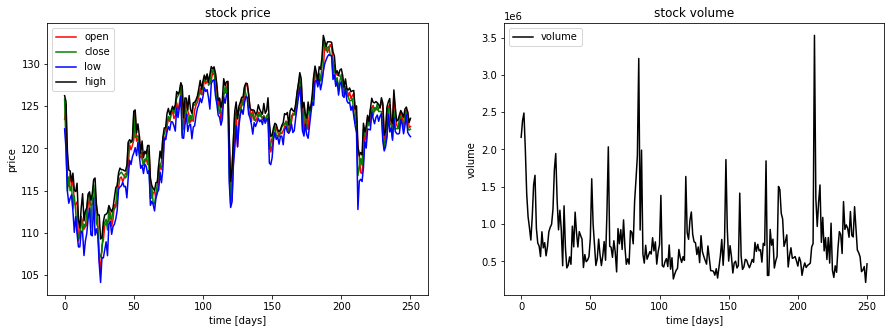

In [14]:
#绘制单一股票的交易信息图
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'WLTW'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'WLTW'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'WLTW'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'WLTW'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'WLTW'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [15]:
# 将相关数据进行最大最小归一化
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# 确定数据的训练步长等相关超参数
def load_data(stock, seq_len):
    data_raw = stock.values # 转置
    data = []
    
    # 确定序列长度
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# 选择数据，并删除多余项
df_stock = df[df.symbol == 'WLTW'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# 归一化
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# 创建训练/测试/验证集
seq_len = 20 
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (185, 19, 4)
y_train.shape =  (185, 4)
x_valid.shape =  (23, 19, 4)
y_valid.shape =  (23, 4)
x_test.shape =  (23, 19, 4)
y_test.shape =  (23, 4)


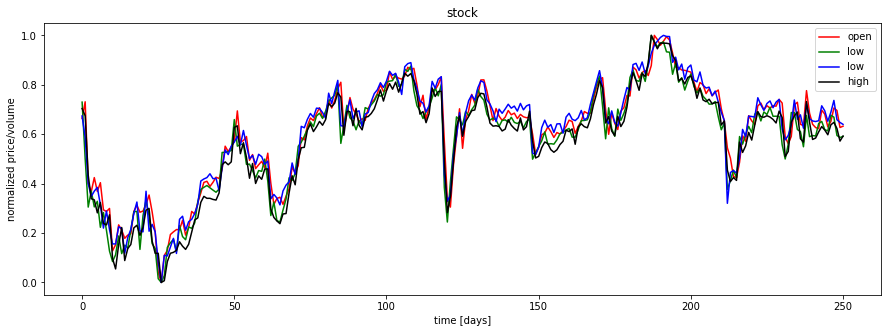

In [16]:
#绘制归一化后的走势图
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [ ]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) 
        start = 0 
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# RNN
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# LSTM
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# LSTM-peephole
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# GRU
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] 
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# 运行
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})